# SVHN Dataset - Original Images

#### Preprocessing of the original images from the SVHN dataset

---

This notebook describes my approach to load and preprocess the original images from the SVHN dataset. The dataset consists of variable-resolution images with character level bounding boxes. I have used this notebook to create 32 x 32 pixel images. As a general note the input layer (that contains the image) should be divisible by 2 many times. Common numbers include 32 (e.g. CIFAR-10), 64, 96 (e.g. STL-10), or 224 (e.g. common ImageNet ConvNets), 384, and 512.

#### Preprocessing steps:

1. One street view image contains more than five digits and is removed. This means that our model assumes that the sequence length is at most 5
2. We crop the images by finding the bounding boxes of each individual character, expand this box by 30% in the x and y direction and crop the image to that bounding box and resize the crop to 32x32
3. Convert the images to greyscale

The [original paper](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf) mentions cropping 54x54 images from random locations within the 64 x 64 pixels in order to increase the size of the dataset.

In [1]:
import os
import sys
import tarfile
import numpy as np
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from IPython.display import display, Image, HTML
import h5py

plt.rcParams['figure.figsize'] = (16.0, 4.0)
%matplotlib inline

After downloading the datasets we need to extract the tarballs.

In [7]:
def extract_tarball(filename, force=False):
    """ Helper function for extracting tarball files
    """
    # Drop the file extension
    root = filename.split('.')[0] 
    
    # If file is already extracted - return
    if os.path.isdir(root) and not force:
        print('%s already present - Skipping extraction of %s.' % (root, filename))
        return
    
    # If file is a tarball file - extract it
    if (filename.endswith("tar.gz")):
        print("Extracting %s ..." % filename)
        tar = tarfile.open(filename, "r:gz")
        tar.extractall()
        tar.close()
        
        
# Get the directory listing for the dataset folder
ls_data = [f for f in os.listdir("/home/suraj/Documents/Minor/svhn-multi-digit-master/") if 'tar.gz' in f]
        
# cd data
os.chdir("/home/suraj/Documents/Minor/svhn-multi-digit-master/")

# Extract the tarballs
#extract_tarball(ls_data[0])
#extract_tarball(ls_data[1])
    
# cd ..
os.chdir(os.path.pardir)

### Bounding boxes

The code for unwrapping the digitStruct files can be found in *unpacker.py*. The digitStruct files contains our labels and information on our bounding boxes which are central to our cropping procedure.

In [8]:

class DigitStructWrapper:
    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        self.digitStructName = self.inf['digitStruct']['name']
        self.digitStructBbox = self.inf['digitStruct']['bbox']

    def get_name(self, n):
        """Return the name of the n(th) digit struct"""
        return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])

    def get_attribute(self, attr):
        """Helper function for dealing with one vs. multiple bounding boxes"""
        if (len(attr) > 1):
            attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr

    def get_bbox(self, n):
        """Return a dict containing the data from the n(th) bbox"""
        bbox = {}
        bb = self.digitStructBbox[n].item()
        bbox['height'] = self.get_attribute(self.inf[bb]["height"])
        bbox['label'] = self.get_attribute(self.inf[bb]["label"])
        bbox['left'] = self.get_attribute(self.inf[bb]["left"])
        bbox['top'] = self.get_attribute(self.inf[bb]["top"])
        bbox['width'] = self.get_attribute(self.inf[bb]["width"])
        return bbox

    def get_item(self, n):
        """Return the name and bounding boxes of a single image"""
        s = self.get_bbox(n)
        s['name'] = self.get_name(n)
        return s

    def unpack(self):
        """Returns a list of dicts containing all the bounding boxes"""
        return [self.get_item(i) for i in range(len(self.digitStructName))]

    def unpack_all(self):
        pictDat = self.unpack()
        result = []
        structCnt = 1
        for i in range(len(pictDat)):
            item = {'filename': pictDat[i]["name"]}
            figures = []
            for j in range(len(pictDat[i]['height'])):
                figure = {}
                figure['height'] = pictDat[i]['height'][j]
                figure['label'] = pictDat[i]['label'][j]
                figure['left'] = pictDat[i]['left'][j]
                figure['top'] = pictDat[i]['top'][j]
                figure['width'] = pictDat[i]['width'][j]
                figures.append(figure)
            structCnt = structCnt + 1
            item['boxes'] = figures
            result.append(item)
        return result

In [10]:
#from unpacker import DigitStructWrapper

def get_bounding_boxes(start_path = '.'):
    """ Extracts a bounding box file and returns a dictionary
    """
    return DigitStructWrapper(start_path).unpack_all()

# Extract the bounding boxes (this will take a while!)
train_bbox = get_bounding_boxes('/home/suraj/Documents/Minor/svhn-multi-digit-master/train/digitStruct.mat')
test_bbox = get_bounding_boxes('/home/suraj/Documents/Minor/svhn-multi-digit-master/test/digitStruct.mat')


# Display the information stored about an individual image
print(json.dumps(train_bbox[0], indent=2))

{
  "filename": "1.png",
  "boxes": [
    {
      "height": 219.0,
      "label": 1.0,
      "left": 246.0,
      "top": 77.0,
      "width": 81.0
    },
    {
      "height": 219.0,
      "label": 9.0,
      "left": 323.0,
      "top": 81.0,
      "width": 96.0
    }
  ]
}


To better understand how the bounding box relates to the images i have written a simple function that displays the image and overlays each bounding box as rectangle with blue edges.

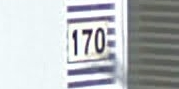

In [11]:
from PIL import Image, ImageDraw

def display_bounding_boxes(img, bounding_boxes):
    """Displays an image and overlays the bounding boxes
    """
    # Opens and identifies the given image file
    image = Image.open(img)
    
    # Use draw module can be used to annotate the image
    draw = ImageDraw.Draw(image)
    
    for b in bounding_boxes:
        
        # Bounding box rectangle [x0, y0, x1, y1]
        rectangle = [b['left'], b['top'], b['left'] + b['width'], b['top'] + b['height']]
        
        # Draw a rectangle on top of the image
        draw.rectangle(rectangle, outline="blue")
        
    # Return altered image    
    return image


# Select an image and the corresponding boxes
image = '/home/suraj/Documents/Minor/svhn-multi-digit-master/train/1953.png'
image_bounding_boxes = train_bbox[0]['boxes']
     
# Display image with bounding boxes
display_bounding_boxes(image, image_bounding_boxes)

To be able to more easily work with the bounding box data, let's move it into a DataFrame to simplify the process of calculating our crops

In [60]:
def dict_to_dataframe(image_bounding_boxes, path):
    """ Helper function for flattening the bounding box dictionary
    """
    # Store each bounding box
    boxes = []
    
    # For each set of bounding boxes
    for image in image_bounding_boxes:
        
        # For every bounding box
        for bbox in image['boxes']:
            
            # Store a dict with the file and bounding box info
            boxes.append({
                    'filename': path + image['filename'],
                    'label': bbox['label'],
                    'width': bbox['width'],
                    'height': bbox['height'],
                    'top': bbox['top'],
                    'left': bbox['left']})
            
    # return the data as a DataFrame
    return pd.DataFrame(boxes)


# We store the bounding boxes here
bbox_file = '/home/suraj/Documents/Minor/svhn-multi-digit-master/bounding_boxes.csv'

if not os.path.isfile(bbox_file):
    
    # Extract every individual bounding box as DataFrame  
    train_df = dict_to_dataframe(train_bbox, '/home/suraj/Documents/Minor/svhn-multi-digit-master/train/')
    test_df = dict_to_dataframe(test_bbox, '/home/suraj/Documents/Minor/svhn-multi-digit-master/test/')
    print("Training", train_df.shape)
    print("Test", test_df.shape)
    print('')

    # Concatenate all the information in a single file
    df = pd.concat([train_df, test_df])
    
    print("Combined", df.shape)

    # Write dataframe to csv
    df.to_csv(bbox_file, index=False)

    # Delete the old dataframes
    del train_df, test_df, train_bbox, test_bbox
    
else:
    # Load preprocessed bounding boxes
    df = pd.read_csv(bbox_file)

# Display the first 10 rows of dataframe
df.head()

,filename,label,width,height,top,left
0,/home/suraj/Documents/Minor/svhn-multi-digit-m...,1.0,81.0,219.0,77.0,246.0
1,/home/suraj/Documents/Minor/svhn-multi-digit-m...,9.0,96.0,219.0,81.0,323.0
2,/home/suraj/Documents/Minor/svhn-multi-digit-m...,2.0,23.0,32.0,29.0,77.0
3,/home/suraj/Documents/Minor/svhn-multi-digit-m...,3.0,26.0,32.0,25.0,98.0
4,/home/suraj/Documents/Minor/svhn-multi-digit-m...,2.0,8.0,15.0,5.0,17.0


#### Grouping the images by image

In our cropping procedure we expand the bounding box by 30% in the x and y direction and crop the image. We start by finding the digit sequence bounding box by taking the minimum (x0, y0) and maximum (x1, y1) of each image.

In [61]:
# Rename the columns to more suitable names
df.rename(columns={'left': 'x0', 'top': 'y0'}, inplace=True)

# Calculate x1 and y1
df['x1'] = df['x0'] + df['width']
df['y1'] = df['y0'] + df['height']

# Perform the following aggregations
aggregate = {'x0':'min',
             'y0':'min',
             'x1':'max',
             'y1':'max',
             'label':(lambda x: list(x),'count')}

# Apply the aggration
df = df.groupby('filename').agg(aggregate).reset_index()
df.rename(columns={'<lambda_0>': 'labels', 'count':'num_digits'}, inplace=True)
# Fix the column names after aggregation
df.columns = [x[0] if i < 5 else x[1] for i, x in enumerate(df.columns.values)]

# Display the results
df.head()

,filename,x0,y0,x1,y1,labels,num_digits
0,/home/suraj/Documents/Minor/svhn-multi-digit-m...,43.0,7.0,62.0,37.0,[5.0],1
1,/home/suraj/Documents/Minor/svhn-multi-digit-m...,16.0,19.0,38.0,40.0,"[1.0, 6.0]",2
2,/home/suraj/Documents/Minor/svhn-multi-digit-m...,124.0,65.0,152.0,99.0,"[6.0, 1.0]",2
3,/home/suraj/Documents/Minor/svhn-multi-digit-m...,210.0,59.0,245.0,87.0,"[2.0, 7.0]",2
4,/home/suraj/Documents/Minor/svhn-multi-digit-m...,35.0,11.0,66.0,32.0,"[1.0, 4.0, 3.0]",3


Let's draw a new bounding box to verify that everything is still looking fine

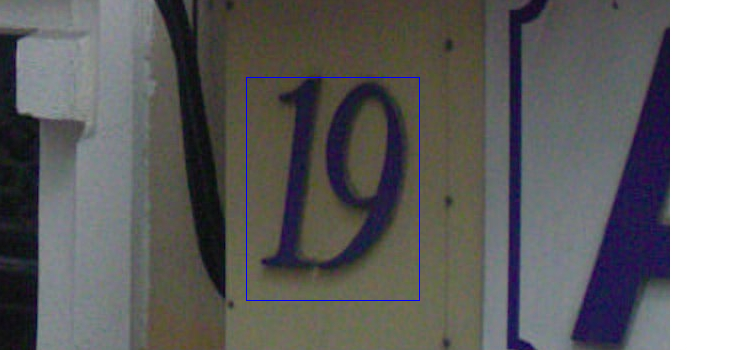

In [48]:
from PIL import Image, ImageDraw

def display_bbox(image_path, bbox):
    """ Helper function to display a single image and bounding box
    """
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    draw.rectangle([bbox['x0'], bbox['y0'], bbox['x1'], bbox['y1']], outline="blue")
    return image


# Select a image and bounding box
image = '/home/suraj/Documents/Minor/svhn-multi-digit-master/train/1.png'
bbox = df[df.filename == image]

# Display image
display_bbox(image, bbox)

Let's expand our bounding boxes by 30% in both directions and use this as a basis for our cropping

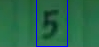

In [64]:
# Calculate the increase in both directions
df['x_increase'] = ((df['x1'] - df['x0']) * 0.3) / 2.
df['y_increase'] = ((df['y1'] - df['y0']) * 0.3) / 2.

# Apply the increase in all four directions
df['x0'] = (df['x0'] - df['x_increase']).astype('int')
df['y0'] = (df['y0'] - df['y_increase']).astype('int')
df['x1'] = (df['x1'] + df['x_increase']).astype('int')
df['y1'] = (df['y1'] + df['y_increase']).astype('int')


# Select the dataframe row corresponding to our image
image = '/home/suraj/Documents/Minor/svhn-multi-digit-master/test/1.png'
bbox = df[df.filename == image]

# Display image
display_bbox(image, bbox)

### Image sizes

The digitStruct files did not contain any information on the file sizes of the images. Since this information could be relevant for our preprocessing, e.g. in case we want to remove low-quality images or improve our cropping procedure.

In [67]:
def get_image_size(filepath):
    """Returns the image size in pixels given as a 2-tuple (width, height)
    """
    image = Image.open(filepath)
    return image.size 

def get_image_sizes(folder):
    """Returns a DataFrame with the file name and size of all images contained in a folder
    """
    image_sizes = []
    
    # Get all .png images contained in the folder
    images = [img for img in os.listdir(folder) if img.endswith('.png')]
    
    # Get image size of every individual image
    for image in images:
        w, h = get_image_size(folder + image)
        image_size = {'filename': folder + image, 'image_width': w, 'image_height': h}
        image_sizes.append(image_size)
        
    # Return results as a pandas DataFrame
    return pd.DataFrame(image_sizes)


# Extract the image sizes
train_sizes = get_image_sizes('/home/suraj/Documents/Minor/svhn-multi-digit-master/train/')
test_sizes = get_image_sizes('/home/suraj/Documents/Minor/svhn-multi-digit-master/test/')


In [68]:

# Concatenate all the information in a single file
image_sizes = pd.concat([train_sizes, test_sizes])

# Display 10 image sizes
image_sizes.head(10)

,filename,image_width,image_height
0,/home/suraj/Documents/Minor/svhn-multi-digit-m...,66,21
1,/home/suraj/Documents/Minor/svhn-multi-digit-m...,331,147
2,/home/suraj/Documents/Minor/svhn-multi-digit-m...,348,238
3,/home/suraj/Documents/Minor/svhn-multi-digit-m...,394,196
4,/home/suraj/Documents/Minor/svhn-multi-digit-m...,114,44
5,/home/suraj/Documents/Minor/svhn-multi-digit-m...,90,35
6,/home/suraj/Documents/Minor/svhn-multi-digit-m...,173,74
7,/home/suraj/Documents/Minor/svhn-multi-digit-m...,65,33
8,/home/suraj/Documents/Minor/svhn-multi-digit-m...,74,38
9,/home/suraj/Documents/Minor/svhn-multi-digit-m...,59,28


Let's merge the new data into our previously created dataframe.

In [69]:
print("Bounding boxes", df.shape)
print("Image sizes", image_sizes.shape)
print('')

# Inner join the datasets on filename
df = pd.merge(df, image_sizes, on='filename', how='inner')

print("Combined", df.shape)

# Store checkpoint
df.to_csv("/home/suraj/Documents/Minor/svhn-multi-digit-master/image_data.csv", index=False)
#df = pd.read_csv('data/image_data.csv')

df.head()

Bounding boxes (46470, 9)
Image sizes (46470, 3)

Combined (46470, 11)


,filename,x0,y0,x1,y1,labels,num_digits,x_increase,y_increase,image_width,image_height
0,/home/suraj/Documents/Minor/svhn-multi-digit-m...,36,-3,67,46,[5.0],1,3.60,5.85,99,47
1,/home/suraj/Documents/Minor/svhn-multi-digit-m...,7,10,45,47,"[1.0, 6.0]",2,4.35,4.20,87,55
2,/home/suraj/Documents/Minor/svhn-multi-digit-m...,113,52,161,110,"[6.0, 1.0]",2,5.55,6.75,353,133
3,/home/suraj/Documents/Minor/svhn-multi-digit-m...,197,48,256,96,"[2.0, 7.0]",2,6.90,5.55,625,239
4,/home/suraj/Documents/Minor/svhn-multi-digit-m...,24,2,76,39,"[1.0, 4.0, 3.0]",3,6.00,4.20,171,42


We can now make some correction to the bounding boxes to make sure that they are contained by the image.

In [70]:
# Correct bounding boxes not contained by image
df.loc[df['x0'] < 0, 'x0'] = 0
df.loc[df['y0'] < 0, 'y0'] = 0
df.loc[df['x1'] > df['image_width'], 'x1'] = df['image_width']
df.loc[df['y1'] > df['image_height'], 'y1'] = df['image_width']

df.head()

,filename,x0,y0,x1,y1,labels,num_digits,x_increase,y_increase,image_width,image_height
0,/home/suraj/Documents/Minor/svhn-multi-digit-m...,36,0,67,46,[5.0],1,3.60,5.85,99,47
1,/home/suraj/Documents/Minor/svhn-multi-digit-m...,7,10,45,47,"[1.0, 6.0]",2,4.35,4.20,87,55
2,/home/suraj/Documents/Minor/svhn-multi-digit-m...,113,52,161,110,"[6.0, 1.0]",2,5.55,6.75,353,133
3,/home/suraj/Documents/Minor/svhn-multi-digit-m...,197,48,256,96,"[2.0, 7.0]",2,6.90,5.55,625,239
4,/home/suraj/Documents/Minor/svhn-multi-digit-m...,24,2,76,39,"[1.0, 4.0, 3.0]",3,6.00,4.20,171,42


### Removing images with more than 5 digits

We have one image with more than 5 digits, let's remove it!

In [71]:
# Count the number of images by number of digits
df.num_digits.value_counts(sort=False)

1     7620
2    26486
3    10772
4     1580
5       11
6        1
Name: num_digits, dtype: int64

In [72]:
# Keep only images with less than 6 digits
df = df[df.num_digits < 6]

### Low quality images

We have some images in the dataset that are very, very small. We should verify that some of these images looks OK after cropping and scaling them to 64 x 64 pixels.

In [73]:
df[['image_width', 'image_height']].describe().round(decimals=2)

,image_width,image_height
count,46469.00,46469.00
mean,140.74,61.25
std,96.36,42.01
min,25.00,12.00
25%,78.00,34.00
50%,111.00,49.00
75%,171.00,75.00
max,1083.00,516.00


### Cropping the images

Let's crop our images using by using our expanded bounding boxes and reshape our labels into a more convenient format. 

In [74]:
#from scipy.ndimage import imread
#from scipy.misc import imresize
import cv2

# Change this to select a different image size
image_size = (32, 32)

def crop_and_resize(image, img_size):
    """ Crop and resize an image
    """
    image_data = cv2.imread(image['filename'])
    #image_data = imread(image['filename'])
    crop = image_data[image['y0']:image['y1'], image['x0']:image['x1'], :]
    #return imresize(crop, img_size)
    return cv2.resize(crop,img_size)

def create_dataset(df, img_size):
    """ Helper function for converting images into a numpy array
    """
    # Initialize the numpy arrays (0's are stored as 10's)
    X = np.zeros(shape=(df.shape[0], img_size[0], img_size[0], 3), dtype='uint8')
    y = np.full((df.shape[0], 5), 10, dtype=int)
    
    # Iterate over all images in the pandas dataframe (slow!)
    for i, (index, image) in enumerate(df.iterrows()):
        
        # Get the image data
        X[i] = crop_and_resize(image, img_size)
        
        # Get the label list as an array
        labels = np.array((image['labels']))
                
        # Store 0's as 0 (not 10)
        labels[labels==10] = 0
        
        # Embed labels into label array
        y[i,0:labels.shape[0]] = labels
        
    # Return data and labels   
    return X, y


#df[df.filename.str.contains('train')]

# Get cropped images and labels (this might take a while...)
X_train, y_train = create_dataset(df[df.filename.str.contains('train')], image_size)
X_test, y_test = create_dataset(df[df.filename.str.contains('test')], image_size)

print("Training", X_train.shape, y_train.shape)
print("Test", X_test.shape, y_test.shape)

Training (33401, 32, 32, 3) (33401, 5)
Test (13068, 32, 32, 3) (13068, 5)


Our newly cropped images now look like this

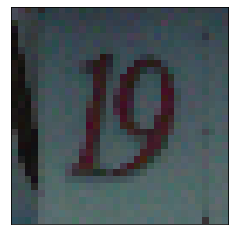

In [75]:
# Plot a cropped image
plt.imshow(X_train[0])
plt.xticks([]); plt.yticks([]);

### Sanity check

Now that we have extracted the images and bounding box information, let's visualize the images to verify that the crops look good and that our labels still match the images.

In [76]:
def plot_images(images, nrows, ncols, cls_true, cls_pred=None):
    """ Helper function for plotting nrows * ncols images
    """
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 2*nrows))
    for i, ax in enumerate(axes.flat): 
        # Pretty string with actual label
        true_number = ''.join(str(x) for x in cls_true[i] if x != 10)
        if cls_pred is None:
            title = "True: {0}".format(true_number)
        else:
            # Pretty string with predicted label
            pred_number = ''.join(str(x) for x in cls_pred[i] if x != 10)
            title = "True: {0}, Pred: {1}".format(true_number, pred_number)  
        ax.imshow(images[i])
        ax.set_title(title)   
        ax.set_xticks([]); ax.set_yticks([])

Let's plot some images from all our dataset to make sure everything looks ok!

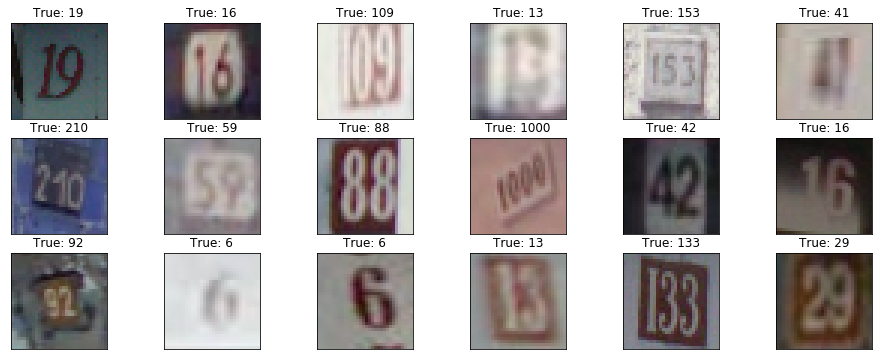

In [77]:
# Display images from the training set
plot_images(X_train, 3, 6, y_train);

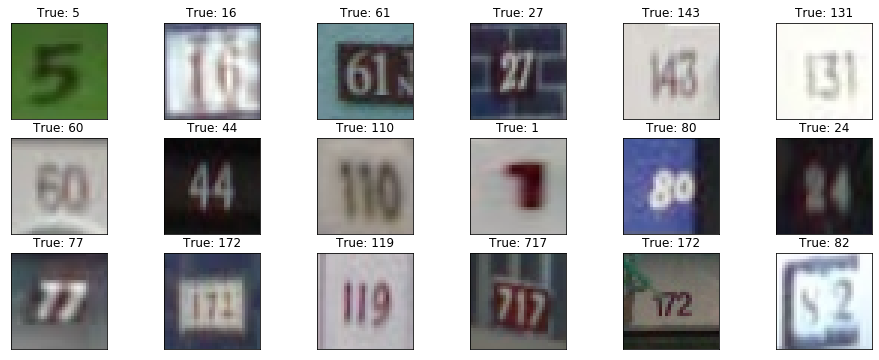

In [78]:
# Display images from the test set
plot_images(X_test, 3, 6, y_test);

#### Scale Invariance

Let's check the edge cases (1 and 5 digits) to check how much scale invariance we have introduced to our dataset through our cropping and rescaling procedure. I imagine that the crops for images with 1 digit have a fairly high height and small width causing the images to be stretched out horizontally when it is resized. The opposite might apply to images with 5 digits where our images could be stretched out vertically. However, due to the aspect ratio of the original images it is hard to get around this issue without substantial work.

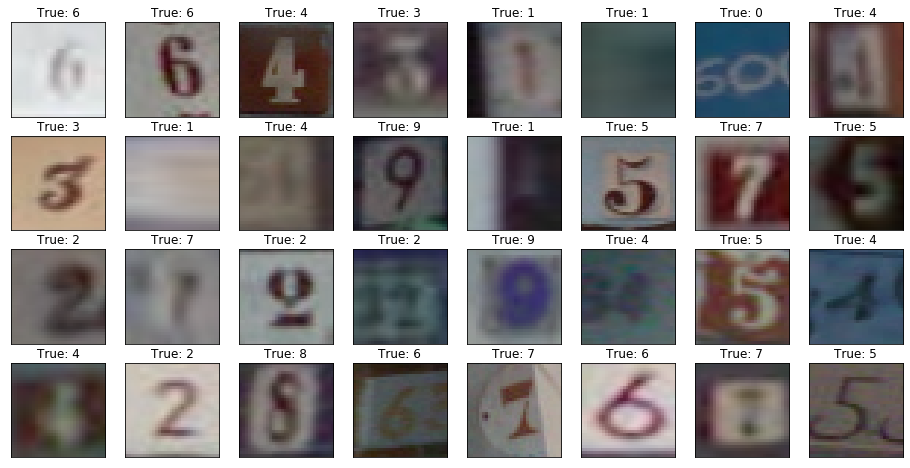

In [79]:
# Find some images containing 1 digit
single_digit = (y_train != 10).sum(1) == 1

# Display some exaples
plot_images(X_train[single_digit], 4, 8, y_train[single_digit]);

Let's take a closer look at sequence length distribution of our images by plotting a few histograms.

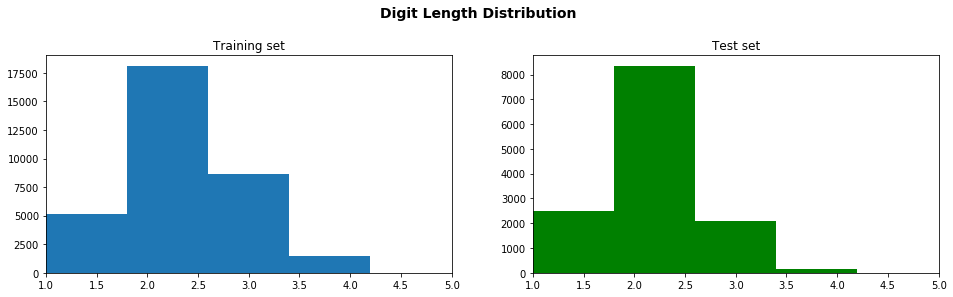

In [80]:
# Initialize the subplotgrid
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(16, 4))

# Set the main figure title
fig.suptitle('Digit Length Distribution', fontsize=14, fontweight='bold', y=1.05)

# Sequence length distribution - training set 
ax1.hist((y_train != 10).sum(1), bins=5)
ax1.set_title("Training set");
ax1.set_xlim(1, 5)

# Sequence length distribution - test set 
ax2.hist((y_test != 10).sum(1), bins=5, color='g')
ax2.set_title("Test set");


We can see that 1-3 digits occur most frequently while images with 4 and 5 digits are relatively rare

### Creating a validation set

Let's create a balanced validation set with an equal number of images with the same digit sequence lengths. The extra set is a large set of easy samples and train set is a smaller set of more difficult samples. We compose our validation set of 6000 samples with 2/3 taken from the training set and 1/3 from the extra set.

In [81]:
def random_sample(N, K):
    """Return a boolean mask of size N with K selections
    """
    mask = np.array([True]*K + [False]*(N-K))
    np.random.shuffle(mask)
    return mask

# Pick 4000 training and 2000 extra samples
sample1 = random_sample(X_train.shape[0], 3000)

# Create valdidation from the sampled data
X_val = X_train[sample1]
y_val = y_train[sample1]

# Keep the data not contained by sample
X_train = X_train[~sample1]
y_train = y_train[~sample1]


print("Training", X_train.shape, y_train.shape)
print('Validation', X_val.shape, y_val.shape)

Training (30401, 32, 32, 3) (30401, 5)
Validation (3000, 32, 32, 3) (3000, 5)


Let's examine our new datasets to make sure everything looks good.

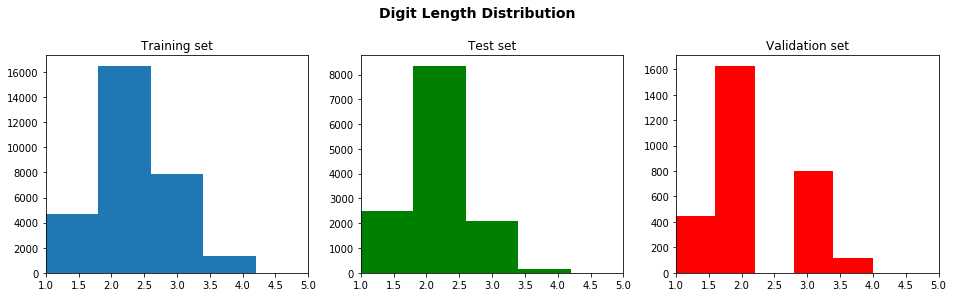

In [82]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, figsize=(16, 4))

fig.suptitle('Digit Length Distribution', fontsize=14, fontweight='bold', y=1.05)

ax1.hist((y_train != 10).sum(1), bins=5)
ax1.set_title("Training set");
ax1.set_xlim(1, 5)

ax2.hist((y_test != 10).sum(1), bins=5, color='g')
ax2.set_title("Test set");

ax3.hist((y_val != 10).sum(1), bins=5, color='r')
ax3.set_title("Validation set");

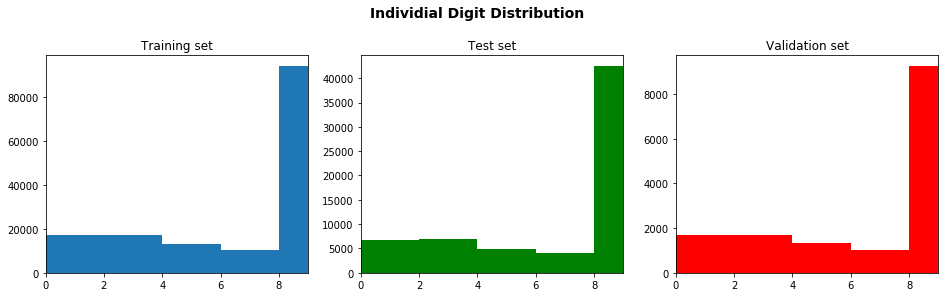

In [83]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, figsize=(16, 4))

fig.suptitle('Individial Digit Distribution', fontsize=14, fontweight='bold', y=1.05)

ax1.hist(y_train.flatten(), bins=5)
ax1.set_title("Training set");
ax1.set_xlim(0, 9)

ax2.hist(y_test.flatten(), bins=5, color='g')
ax2.set_title("Test set");

ax3.hist(y_val.flatten(), bins=5, color='r')
ax3.set_title("Validation set");

### Storing the Data

Let's store our RGB images before converting them to greyscale.

In [85]:
# Create file
h5f = h5py.File('/home/suraj/Documents/Minor/svhn-multi-digit-master/SVHN_multi_data.h5', 'w')

# Store the datasets
h5f.create_dataset('train_dataset', data=X_train)
h5f.create_dataset('train_labels', data=y_train)
h5f.create_dataset('test_dataset', data=X_test)
h5f.create_dataset('test_labels', data=y_test)
h5f.create_dataset('valid_dataset', data=X_val)
h5f.create_dataset('valid_labels', data=y_val)

# Close the file
h5f.close()

Let's convert our images to greyscale and store another copy. To convert RBG values to grayscale we can take a weighted sum of the R, G, and B components. 

In [86]:
def rgb2gray(images):
    """Convert images from rbg to grayscale
    """
    greyscale = np.dot(images, [0.2989, 0.5870, 0.1140])
    return np.expand_dims(greyscale, axis=3)


# Transform the images to greyscale
X_train = rgb2gray(X_train).astype(np.float32)
X_test = rgb2gray(X_test).astype(np.float32)
X_val = rgb2gray(X_val).astype(np.float32)

Now that our images have been converted to greyscale, let's store them!

In [87]:
# Create file
h5f = h5py.File('/home/suraj/Documents/Minor/svhn-multi-digit-master/SVHN_multi_grey_data.h5', 'w')

# Store the datasets
h5f.create_dataset('train_dataset', data=X_train)
h5f.create_dataset('train_labels', data=y_train)
h5f.create_dataset('test_dataset', data=X_test)
h5f.create_dataset('test_labels', data=y_test)
h5f.create_dataset('valid_dataset', data=X_val)
h5f.create_dataset('valid_labels', data=y_val)

# Close the file
h5f.close()

## Capturing data from camera (Under development)

In [88]:
cam = cv2.VideoCapture(0)

cv2.namedWindow("test")

img_counter = 0

while True:
    ret, frame = cam.read()
    cv2.imshow("test", frame)
    if not ret:
        break
    k = cv2.waitKey(1)

    if k%256 == 27:
        # ESC pressed
        print("Escape hit, closing...")
        break
    elif k%256 == 32:
        # SPACE pressed
        img_name = "opencv_frame_{}.png".format(img_counter)
        cv2.imwrite('C:/Users/Suraj Tiwari/Desktop/'+img_name, frame)
        print("{} written!".format(img_name))
        img_counter += 1

cam.release()

cv2.destroyAllWindows()

opencv_frame_0.png written!
opencv_frame_1.png written!
Escape hit, closing...


In [101]:
imageX = cv2.imread('C:/Users/Suraj Tiwari/Desktop/opencv_frame_0.png')

In [102]:
imageX1 = cv2.imread('C:/Users/Suraj Tiwari/Desktop/opencv_frame_1.png')

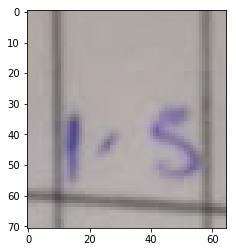

In [103]:
plt.imshow(imageX1)